# Use of foscat to forecast ECMWF global information

This notebook ....

## TODO:

- Problem while using statistics of the previous timestep, should compress dimensinality of foscat

## Installation of required packages

In [1]:
#!pip install foscat==3.1.0 
#!pip install --upgrade "xarray<=2025.4.0"

In [2]:
!pip uninstall foscat -y
!pip install git+https://github.com/jmdelouis/FOSCAT.git@CNNV1
#!pip install gcsfs
#!pip install xarray-eopf
#!pip install torch

  Cloning https://github.com/jmdelouis/FOSCAT.git (to revision CNNV1) to /tmp/pip-req-build-2m_55fs2
  Running command git clone --filter=blob:none --quiet https://github.com/jmdelouis/FOSCAT.git /tmp/pip-req-build-2m_55fs2
  Running command git checkout -b CNNV1 --track origin/CNNV1
  Switched to a new branch 'CNNV1'
  branch 'CNNV1' set up to track 'origin/CNNV1'.
  Resolved https://github.com/jmdelouis/FOSCAT.git to commit dd42e0c5255bb882427cfc5bae773cb3b0665226
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached healpy-1.18.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.1 kB)
  Using cached spherical-1.0.18-py3-none-any.whl.metadata (7.7 kB)
  Using cached quaternionic-1.0.17-py3-none-any.whl.metadata (18 kB)
  Using cached spinsfast-2022.4.10-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (520 bytes)
Using cached healpy-1.18.1-cp312-cp31

In [3]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import foscat.scat_cov as sc
import foscat.Synthesis as synthe

### Choose the resolution

In [4]:
nside=32

In [5]:
import gcsfs
import xarray
gcs = gcsfs.GCSFileSystem(token='anon')

era5_path = 'gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3'
full_era5 = xarray.open_zarr(gcs.get_mapper(era5_path), chunks=None)
full_era5

<xarray.Dataset> Size: 4PB
Dimensions:                                                          (
                                                                      time: 1323648,
                                                                      latitude: 721,
                                                                      longitude: 1440,
                                                                      level: 37)
Coordinates:
  * latitude                                                         (latitude) float32 3kB ...
  * level                                                            (level) int64 296B ...
  * longitude                                                        (longitude) float32 6kB ...
  * time                                                             (time) datetime64[ns] 11MB ...
Data variables: (12/273)
    100m_u_component_of_wind                                         (time, latitude, longitude) float32 5TB ...
    100m_v_component_of_wind                                         (time, latitude, longitude) float32 5TB ...
    10m_u_component_of_neutral_wind                                  (time, latitude, longitude) float32 5TB ...
    10m_u_component_of_wind                                          (time, latitude, longitude) float32 5TB ...
    10m_v_component_of_neutral_wind                                  (time, latitude, longitude) float32 5TB ...
    10m_v_component_of_wind                                          (time, latitude, longitude) float32 5TB ...
    ...                                                               ...
    wave_spectral_directional_width_for_swell                        (time, latitude, longitude) float32 5TB ...
    wave_spectral_directional_width_for_wind_waves                   (time, latitude, longitude) float32 5TB ...
    wave_spectral_kurtosis                                           (time, latitude, longitude) float32 5TB ...
    wave_spectral_peakedness                                         (time, latitude, longitude) float32 5TB ...
    wave_spectral_skewness                                           (time, latitude, longitude) float32 5TB ...
    zero_degree_level                                                (time, latitude, longitude) float32 5TB ...
Attributes:
    last_updated:           2025-09-29 01:55:09.136848+00:00
    valid_time_start:       1940-01-01
    valid_time_stop:        2025-04-30
    valid_time_stop_era5t:  2025-09-23

In [6]:
temperature=full_era5['sea_surface_temperature'] # the nearest from the surface
temperature

<xarray.DataArray 'sea_surface_temperature' (time: 1323648, latitude: 721,
                                             longitude: 1440)> Size: 5TB
[1374264299520 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * time       (time) datetime64[ns] 11MB 1900-01-01 ... 2050-12-31T23:00:00
Attributes:
    long_name:   Sea surface temperature
    short_name:  sst
    units:       K

In [46]:
tisr=full_era5['toa_incident_solar_radiation']
tisr

<xarray.DataArray 'toa_incident_solar_radiation' (time: 1323648, latitude: 721,
                                                  longitude: 1440)> Size: 5TB
[1374264299520 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * time       (time) datetime64[ns] 11MB 1900-01-01 ... 2050-12-31T23:00:00
Attributes:
    long_name:   TOA incident solar radiation
    short_name:  tisr
    units:       J m**-2

In [50]:
from scipy.interpolate import RegularGridInterpolator

# convert the input data in a nside=nside healpix map based on repixelisation at l_nside
def to_Flat(arr_val,itime,nside,l_nside=512):
    im=arr_val.isel(time=itime).compute().to_numpy()

    x_pix=np.repeat(((np.arange(im.shape[0])+0.5)*(nside*3)/im.shape[0]).astype('int'),im.shape[1])
    y_pix=np.tile((((np.arange(im.shape[1])+im.shape[1]//2+0.5)*(nside*4)/im.shape[1]).astype('int'))%(4*nside),im.shape[0])

    resh = np.bincount(x_pix*4*nside+y_pix,minlength=12*nside**2)
    res  = np.bincount(x_pix*4*nside+y_pix,im.flatten(),minlength=12*nside**2)
    
    return (res/resh).reshape(3*nside,4*nside)

In [ ]:
ntest=1000
nvalid=ntest

try:
    train_im=np.load('train_im_FLAT_%d.npy'%(ntest))
    train_sun=np.load('train_sun_FLAT_%d.npy'%(ntest))
except:
    train_im=np.zeros([ntest,3*nside,4*nside])
    train_sun=np.zeros([ntest,3*nside,4*nside])

    for k in range(ntest):
        print('test ',k,train_im[k,10,30])
        train_im[k]=to_Flat(temperature,1000000+24*k,nside)
        train_sun[k]=to_Flat(tisr,1000000+24*k,nside)
    
    np.save('train_im_FLAT_%d.npy'%(ntest),train_im)
    np.save('train_sun_FLAT_%d.npy'%(ntest),train_sun)

try:
    valid_im=np.load('valid_im_FLAT_%d.npy'%(ntest))
    valid_sun=np.load('valid_sun_FLAT_%d.npy'%(ntest))
    
except:
    valid_im=np.zeros([nvalid,3*nside,4*nside])
    valid_sun=np.zeros([nvalid,3*nside,4*nside])
    
    for k in range(nvalid):
        print('valid ',k)
        valid_im[k]=to_Flat(temperature,1000000+24*(ntest+k),nside)
        valid_sun[k]=to_Flat(tisr,1000000+24*(ntest+k),nside)
    
    np.save('valid_im_FLAT_%d.npy'%(ntest),valid_im)
    np.save('valid_sun_FLAT_%d.npy'%(ntest),valid_sun)
print(train_im.shape,valid_im.shape)

valid  0
valid  1
valid  2
valid  3
valid  4
valid  5
valid  6
valid  7
valid  8
valid  9
valid  10
valid  11
valid  12
valid  13
valid  14
valid  15
valid  16
valid  17
valid  18
valid  19
valid  20
valid  21
valid  22
valid  23
valid  24
valid  25
valid  26
valid  27
valid  28
valid  29
valid  30
valid  31
valid  32
valid  33
valid  34
valid  35
valid  36
valid  37
valid  38
valid  39
valid  40
valid  41
valid  42
valid  43
valid  44
valid  45
valid  46
valid  47
valid  48
valid  49
valid  50
valid  51
valid  52
valid  53
valid  54
valid  55
valid  56
valid  57
valid  58
valid  59
valid  60
valid  61
valid  62
valid  63
valid  64
valid  65
valid  66
valid  67
valid  68
valid  69
valid  70
valid  71
valid  72
valid  73
valid  74
valid  75
valid  76
valid  77
valid  78
valid  79
valid  80
valid  81
valid  82
valid  83
valid  84
valid  85
valid  86
valid  87
valid  88
valid  89
valid  90
valid  91
valid  92
valid  93
valid  94
valid  95
valid  96
valid  97
valid  98
valid  99
valid  100

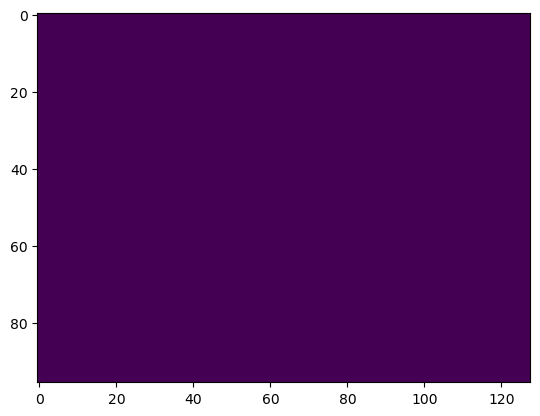

In [66]:
mask=np.isfinite(train_im[0])

train_im[~np.isfinite(train_im)]=285
valid_im[~np.isfinite(valid_im)]=285
plt.imshow(mask)

(33, 1000) (1000, 96, 128)
(33, 96, 128) (33, 33)
303.28362852374437
5.76878674658818
2.7429031965652517
2.7131683067708585
1.971558605633353
0.6944427064302671


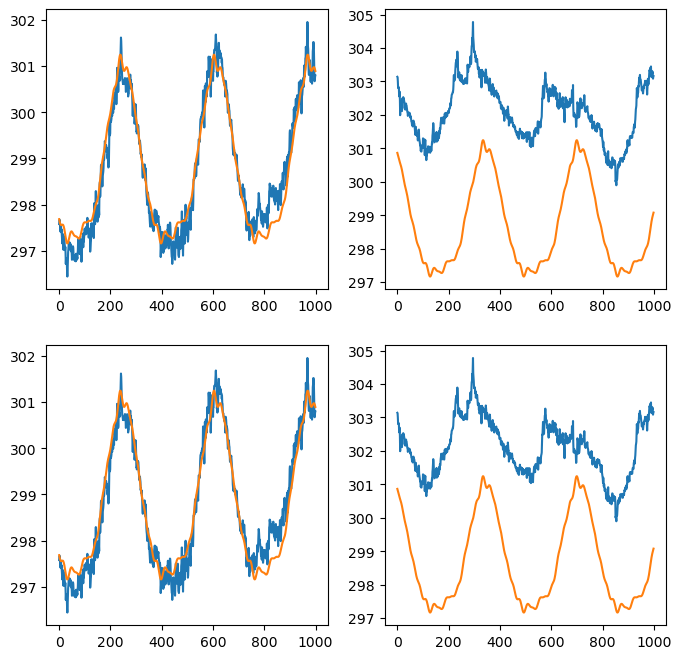

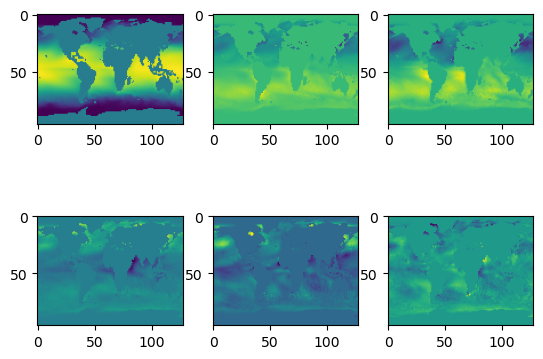

In [67]:
# Build a climato
nharm=16

tab=[np.ones([train_im.shape[0]])[None,:]]
for k in range(nharm):
    tab=tab+[np.cos((k+1)*2*np.pi*np.arange(train_im.shape[0])/365.25)[None,:],
              np.sin((k+1)*2*np.pi*np.arange(train_im.shape[0])/365.25)[None,:]]
train_day=np.concatenate(tab,0)
tab=[np.ones([valid_im.shape[0]])[None,:]]
for k in range(nharm):
    tab=tab+[np.cos((k+1)*2*np.pi*(np.arange(valid_im.shape[0])+train_im.shape[0])/365.25)[None,:],
              np.sin((k+1)*2*np.pi*(np.arange(valid_im.shape[0])+train_im.shape[0])/365.25)[None,:]]
valid_day=np.concatenate(tab,0)

mat_train=np.linalg.pinv(train_day@train_day.T)
mat_valid=np.linalg.pinv(valid_day@valid_day.T)

print(train_day.shape,train_im.shape)
a=np.sum(train_day[:,:,None,None]*train_im[None,...],1)
print(a.shape,mat_train.shape)
a=np.sum(mat_train[:,:,None,None]*a[None,...],1)

train_clim=np.einsum('ijl,ik->kjl',a,train_day)
valid_clim=np.einsum('ijl,ik->kjl',a,valid_day)

plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
plt.plot(train_im[:,40,50])
plt.plot(train_clim[:,40,50])
plt.subplot(2,2,2)
plt.plot(valid_im[:,40,50])
plt.plot(valid_clim[:,40,50])
plt.subplot(2,2,3)
plt.plot(train_im[:,40,50])
plt.plot(train_clim[:,40,50])
plt.subplot(2,2,4)
plt.plot(valid_im[:,40,50])
plt.plot(valid_clim[:,40,50])
plt.figure()
for k in range(6):
    plt.subplot(2,3,1+k)
    plt.imshow(a[k])
    print(np.nanmax(a[k]))

In [68]:
nchan=9
from foscat.unet_2_d_from_healpix_params import PlanarUNet, fit

model = PlanarUNet(
    in_nside=64,
    n_chan_in=nchan,
    chanlist=[32*2**k for k in range(5)],
    KERNELSZ=3,
    task='regression',       # 'regression' ou 'segmentation'
    out_channels=1,            # nb de classes si segmentation
    down_type='max'
)
'''
from foscat.healpix_unet_torch import HealpixUNet,fit
model = HealpixUNet(
    in_nside=nside,
    n_chan_in=nchan,  # previous time step, tisr, DEM
    chanlist=[8 for k in range(4)],
    gauge_type='phi',
    G=8,
    cell_ids=cell_ids,           # finest-resolution nested ids
    KERNELSZ=3,
    head_reduce='learned',
    task='regression',         # or 'regression' or 'segmentation'
    out_channels=1,              # e.g., #classes
    final_activation=None      # defaults: sigmoid if 1 class, else softmax; 'none' for regression
)
'''

"\nfrom foscat.healpix_unet_torch import HealpixUNet,fit\nmodel = HealpixUNet(\n    in_nside=nside,\n    n_chan_in=nchan,  # previous time step, tisr, DEM\n    chanlist=[8 for k in range(4)],\n    gauge_type='phi',\n    G=8,\n    cell_ids=cell_ids,           # finest-resolution nested ids\n    KERNELSZ=3,\n    head_reduce='learned',\n    task='regression',         # or 'regression' or 'segmentation'\n    out_channels=1,              # e.g., #classes\n    final_activation=None      # defaults: sigmoid if 1 class, else softmax; 'none' for regression\n)\n"

In [69]:
ampnorm=1/np.std(train_im)
amptisr=1/5E6

memory=[2**(k) for k in range(nchan-2)]
max_mem=np.max(memory)

# todo rappel pour rpedictibilité temporelle
#train_dem=np.tile(dem[cell_ids],ntest-max_mem-1).reshape(ntest-max_mem-1,1,cell_ids.shape[0])
#valid_dem=np.tile(dem[cell_ids],nvalid-max_mem-1).reshape(nvalid-max_mem-1,1,cell_ids.shape[0])
prev_dt=10
dt=max_mem

train_table=[np.tile(mask.flatten(),train_im.shape[0]-(max_mem+prev_dt)).reshape(train_im.shape[0]-(max_mem+prev_dt),
                                                                                 3*nside,4*nside)[:,None,:,:]]
valid_table=[np.tile(mask.flatten(),valid_im.shape[0]-(max_mem+prev_dt)).reshape(valid_im.shape[0]-(max_mem+prev_dt),
                                                                                 3*nside,4*nside)[:,None,:,:]]
train_table=train_table+[ampnorm*(train_clim[max_mem+prev_dt:]-273)[:,None,:,:]]
valid_table=valid_table+[ampnorm*(valid_clim[max_mem+prev_dt:]-273)[:,None,:,:]]
for k in memory:
    train_table=train_table+[ampnorm*(train_im[max_mem-k:-k-prev_dt]
                                      -train_clim[max_mem-k:-k-prev_dt])[:,None,:,:]]
    valid_table=valid_table+[ampnorm*(valid_im[max_mem-k:-k-prev_dt]
                                      -valid_clim[max_mem-k:-k-prev_dt])[:,None,:,:]]

x_train=model.to_tensor(np.concatenate(train_table,1))
y_train=model.to_tensor(ampnorm*(train_im[max_mem+prev_dt:]-train_clim[max_mem+prev_dt:])[:,None,:,:])

x_valid=model.to_tensor(np.concatenate(valid_table,1))
y_valid=model.to_tensor(ampnorm*(valid_im[max_mem+prev_dt:]-valid_clim[max_mem+prev_dt:])[:,None,:,:])

x_train.shape,y_train.shape

(torch.Size([926, 9, 96, 128]), torch.Size([926, 1, 96, 128]))

In [70]:
print(ntest,x_train.shape)

# refine with LBFGS
hist  = fit(model, x_train,y_train, n_epoch=100, view_epoch=1,optimizer='ADAM',batch_size=10)

1000 torch.Size([926, 9, 96, 128])


KeyboardInterrupt: 

In [59]:
def dopred(x_train,train_clim):
    result=y_train.cpu().numpy()
    for k in range(0,x_train.shape[0],10):
        # Sur CPU: amp=False; sur CUDA: amp=True conseillé
        tmp= model.predict(
            x_train[k:k+10], batch_size=4, amp=True, out_device='cpu', out_dtype='float32'
        ).numpy()+ampnorm*(train_clim[max_mem+prev_dt+k:max_mem+prev_dt+k+10,None]-273) # .cpu() inutile si out_device='cpu'
    
        result[k:k+10]=tmp
    return result
y_pred=dopred(x_train,train_clim)
#y_pred=model.predict(x_train).cpu().numpy()+ampnorm*(train_clim[max_mem+prev_dt:,None,:,:]-273)
inv_norm=1/ampnorm
y_pred.shape


(926, 1, 96, 128)

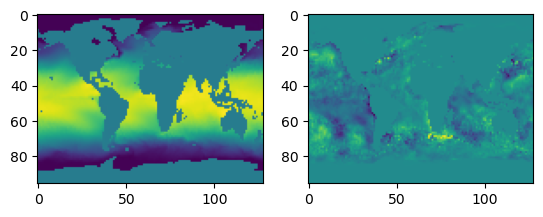

In [60]:
plt.subplot(1,2,1)
plt.imshow(inv_norm*y_pred[0,0])
plt.subplot(1,2,2)
plt.imshow(inv_norm*y_train[0,0].cpu().numpy())

/tmp/ipykernel_90/1340141311.py:8: RuntimeWarning: divide by zero encountered in divide
  plt.imshow((inv_norm*(y_train)[k,0].cpu().numpy()+(train_clim[k+max_mem+prev_dt]-273))/mask,
/tmp/ipykernel_90/1340141311.py:12: RuntimeWarning: divide by zero encountered in divide
  plt.imshow(inv_norm*(y_pred[k,0])/mask,cmap='coolwarm',vmin=amp1,vmax=amp2)
/tmp/ipykernel_90/1340141311.py:15: RuntimeWarning: divide by zero encountered in divide
  plt.imshow((inv_norm*(y_pred[k,0])-(inv_norm*(y_train)[k,0].cpu().numpy()+(train_clim[k+max_mem+prev_dt]-273)))/mask,vmin=-2,vmax=2,cmap='coolwarm')


0.01 736715.43
0.02 736667.33
0.02 736619.11


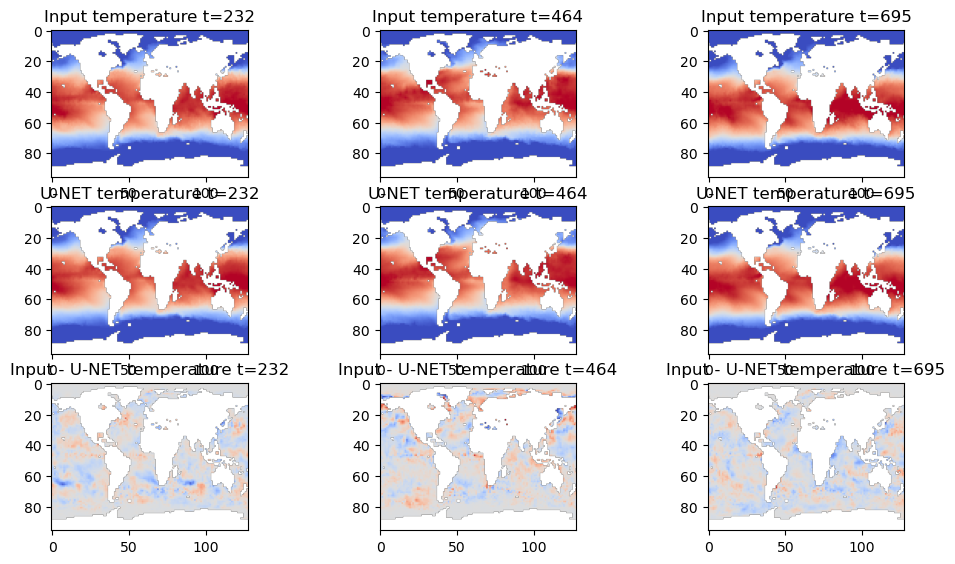

In [61]:
plt.figure(figsize=(12,6.5))
amp1=5
amp2=30
rot=[0,0]
nresult=y_pred.shape[0]
for i, k in enumerate([nresult//4, 2*nresult//4, 3*nresult//4]):
    plt.subplot(3,3,1+i)
    plt.imshow((inv_norm*(y_train)[k,0].cpu().numpy()+(train_clim[k+max_mem+prev_dt]-273))/mask,
               cmap='coolwarm',vmin=amp1,vmax=amp2)
    plt.title(r'Input temperature t=%d'%(k+1))
    plt.subplot(3,3,4+i)
    plt.imshow(inv_norm*(y_pred[k,0])/mask,cmap='coolwarm',vmin=amp1,vmax=amp2)
    plt.title(r'U-NET temperature t=%d'%(k+1))
    plt.subplot(3,3,7+i)
    plt.imshow((inv_norm*(y_pred[k,0])-(inv_norm*(y_train)[k,0].cpu().numpy()+(train_clim[k+max_mem+prev_dt]-273)))/mask,vmin=-2,vmax=2,cmap='coolwarm')
    plt.title(r'Input - U-NET temperature t=%d'%(k+1))
    print("%.2f %.2f"%(inv_norm*np.mean(y_train[k,0].cpu().numpy()**2),inv_norm*np.mean((y_pred[k,0]-ampnorm*(train_clim[k+max_mem+prev_dt]-273)-train_clim[k]-y_train[k,0].cpu().numpy())**2)))

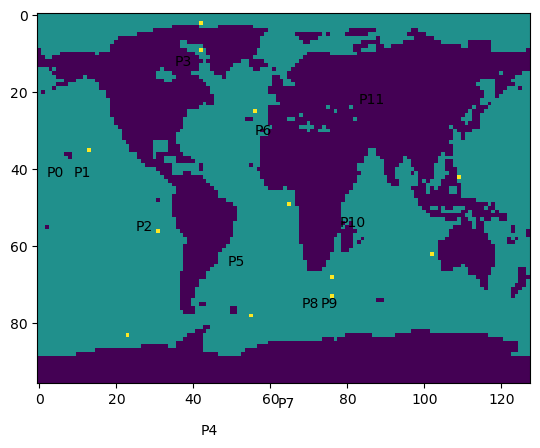

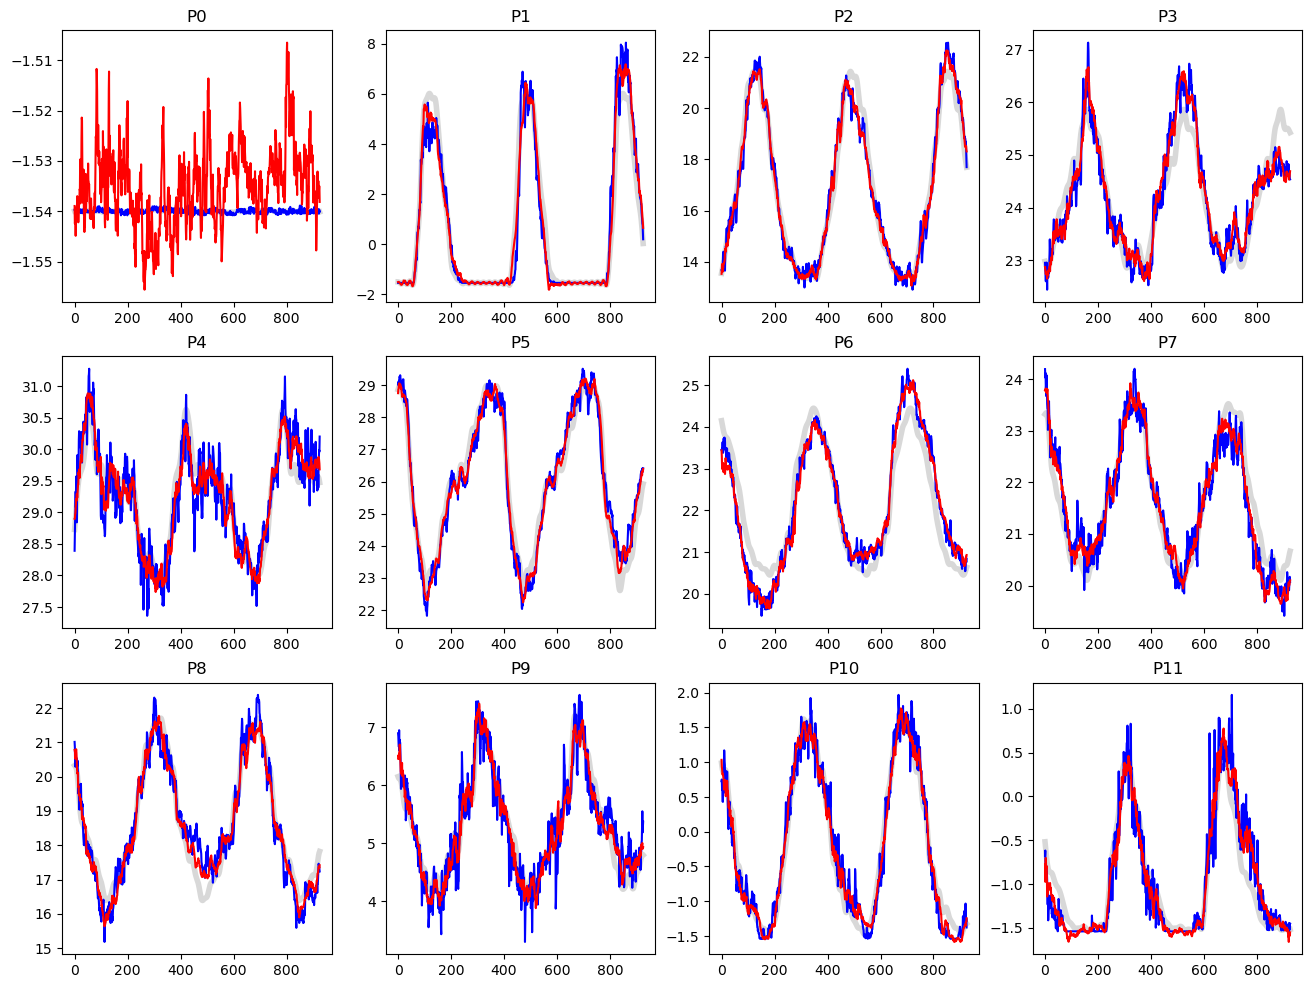

In [62]:
idx=np.where(mask==1)

n=idx[0].shape[0]
im=mask*1.0
for k in range(12):
    j=int((k+0.5)*n/12)
    im[idx[0][j],idx[1][j]]=2.0
plt.figure()
plt.imshow(im)
# Étiquettes : une par point
labels = [f"P{k}" for k in range(12)]  

for k in range(12):
    j=int((k+0.5)*n/12)
    plt.text(idx[0][j],idx[1][j],labels[k])
    
plt.figure(figsize=(16,12))
for k in range(12):
    j=int((k+0.5)*n/12)
    plt.subplot(3,4,1+k)
    plt.title(labels[k])
    plt.plot((train_clim[max_mem+prev_dt:,idx[0][j],idx[1][j]]-273),color='grey',lw=4,alpha=0.3)
    plt.plot(inv_norm*y_train[:,0,idx[0][j],idx[1][j]].cpu().numpy()+(train_clim[max_mem+prev_dt:,idx[0][j],idx[1][j]]-273),color='b')
    plt.plot(inv_norm*y_pred[:,0,idx[0][j],idx[1][j]],color='r')

In [63]:

y_pred=dopred(x_valid,valid_clim)
inv_norm=1/ampnorm
y_pred.shape


(926, 1, 96, 128)

/tmp/ipykernel_90/769274280.py:8: RuntimeWarning: divide by zero encountered in divide
  plt.imshow((inv_norm*(y_valid)[k,0].cpu().numpy()+(valid_clim[k+max_mem+prev_dt]-273))/mask,
/tmp/ipykernel_90/769274280.py:12: RuntimeWarning: divide by zero encountered in divide
  plt.imshow(inv_norm*(y_pred[k,0])/mask,cmap='coolwarm',vmin=amp1,vmax=amp2)
/tmp/ipykernel_90/769274280.py:15: RuntimeWarning: divide by zero encountered in divide
  plt.imshow((inv_norm*(y_pred[k,0])-(inv_norm*(y_valid)[k,0].cpu().numpy()+(valid_clim[k+max_mem+prev_dt]-273)))/mask,vmin=-2,vmax=2,cmap='coolwarm')


6.18 736759.18
5.92 736725.22
5.99 736711.21


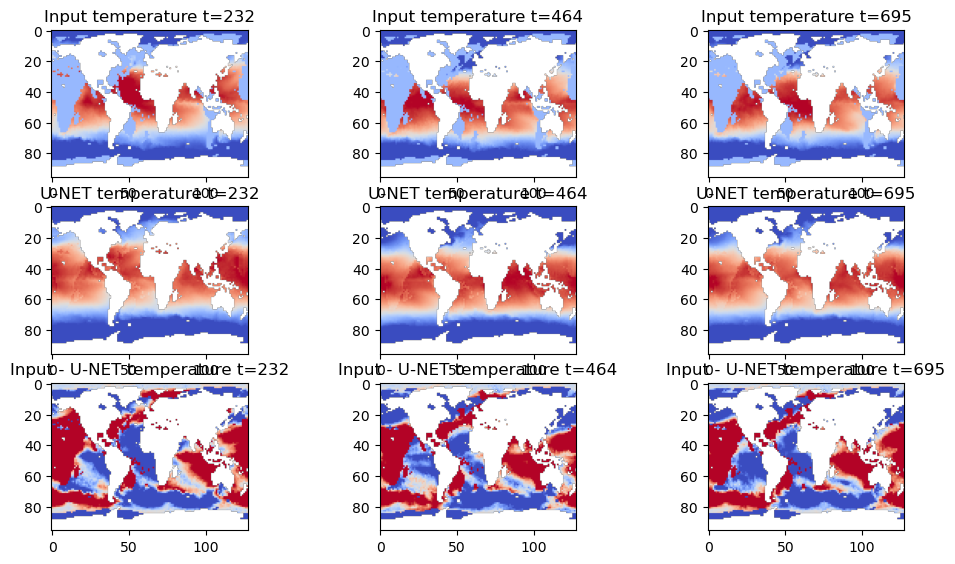

In [64]:
plt.figure(figsize=(12,6.5))
amp1=5
amp2=30
rot=[0,0]
nresult=y_pred.shape[0]
for i, k in enumerate([nresult//4, 2*nresult//4, 3*nresult//4]):
    plt.subplot(3,3,1+i)
    plt.imshow((inv_norm*(y_valid)[k,0].cpu().numpy()+(valid_clim[k+max_mem+prev_dt]-273))/mask,
               cmap='coolwarm',vmin=amp1,vmax=amp2)
    plt.title(r'Input temperature t=%d'%(k+1))
    plt.subplot(3,3,4+i)
    plt.imshow(inv_norm*(y_pred[k,0])/mask,cmap='coolwarm',vmin=amp1,vmax=amp2)
    plt.title(r'U-NET temperature t=%d'%(k+1))
    plt.subplot(3,3,7+i)
    plt.imshow((inv_norm*(y_pred[k,0])-(inv_norm*(y_valid)[k,0].cpu().numpy()+(valid_clim[k+max_mem+prev_dt]-273)))/mask,vmin=-2,vmax=2,cmap='coolwarm')
    plt.title(r'Input - U-NET temperature t=%d'%(k+1))
    print("%.2f %.2f"%(inv_norm*np.mean(y_valid[k,0].cpu().numpy()**2),inv_norm*np.mean((y_pred[k,0]-ampnorm*(valid_clim[k+max_mem+prev_dt]-273)-train_clim[k]-y_train[k,0].cpu().numpy())**2)))

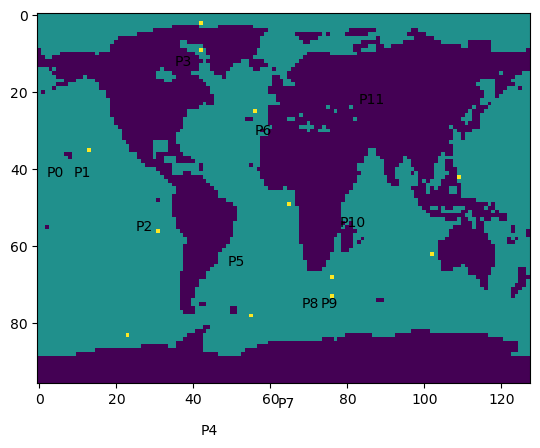

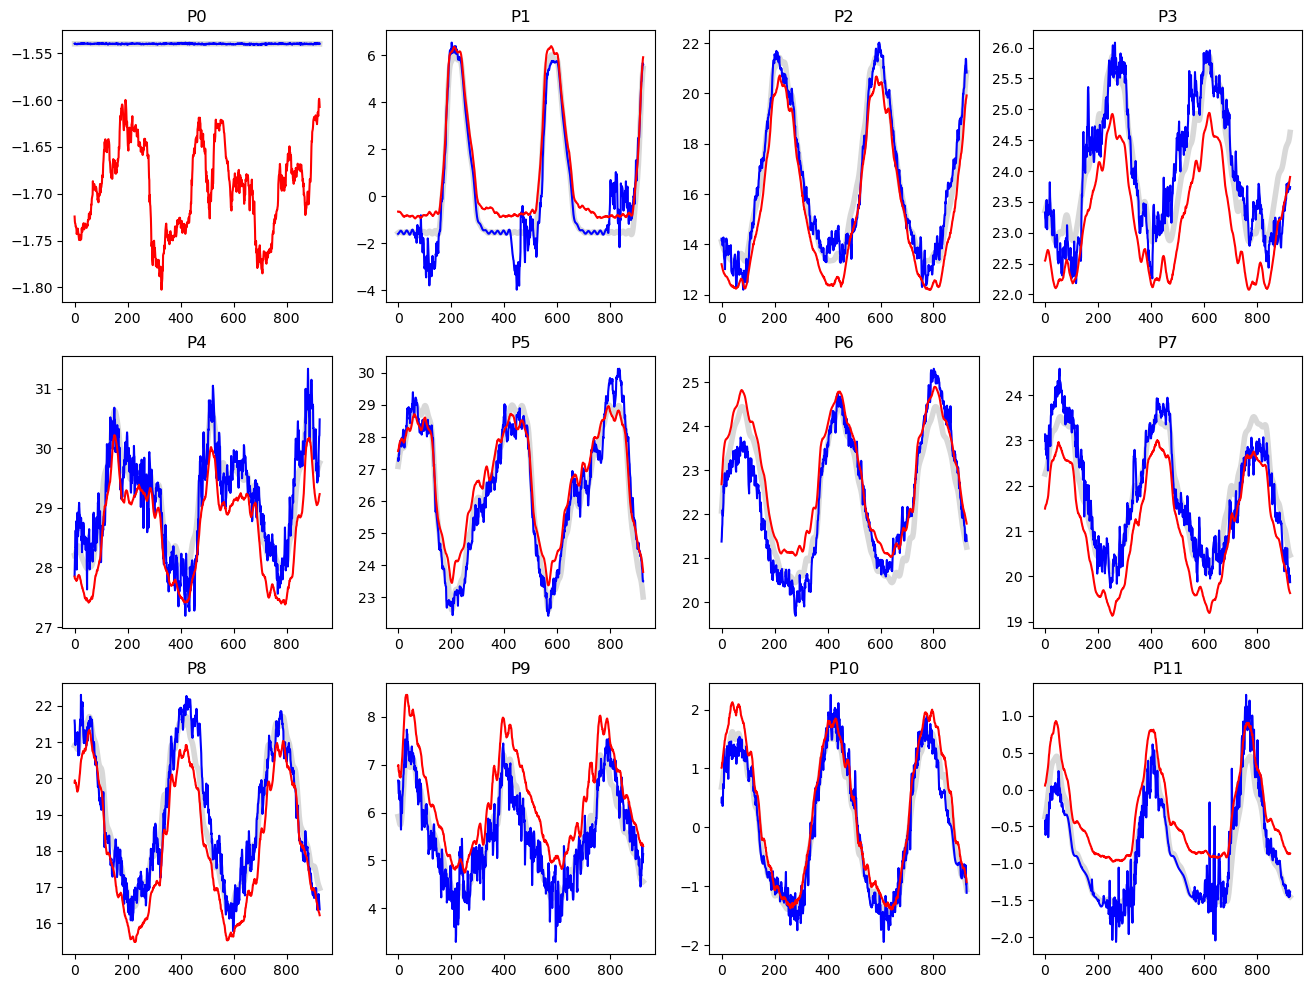

In [65]:
idx=np.where(mask==1)

n=idx[0].shape[0]
im=mask*1.0
for k in range(12):
    j=int((k+0.5)*n/12)
    im[idx[0][j],idx[1][j]]=2.0
plt.figure()
plt.imshow(im)
# Étiquettes : une par point
labels = [f"P{k}" for k in range(12)]  

for k in range(12):
    j=int((k+0.5)*n/12)
    plt.text(idx[0][j],idx[1][j],labels[k])
    
plt.figure(figsize=(16,12))
for k in range(12):
    j=int((k+0.5)*n/12)
    plt.subplot(3,4,1+k)
    plt.title(labels[k])
    plt.plot((valid_clim[max_mem+prev_dt:,idx[0][j],idx[1][j]]-273),color='grey',lw=4,alpha=0.3)
    plt.plot(inv_norm*y_train[:,0,idx[0][j],idx[1][j]].cpu().numpy()+(valid_clim[max_mem+prev_dt:,idx[0][j],idx[1][j]]-273),color='b')
    plt.plot(inv_norm*y_pred[:,0,idx[0][j],idx[1][j]],color='r')